# E-commerce Capstone

## Imports & Loading

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub

# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 2_000_000  # Steam sample size
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(df, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    n = len(df)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return df.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = df.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(df, y, n_rows=None, frac=None, random_state=42):
    if df is None:
        raise ValueError("df is None")
    y_arr = df[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(df)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return df.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(df, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = df.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # choose sampling method
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist (full):", None if olist is None else olist.shape)
print("sales (full):", None if sales is None else sales.shape)


/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 2000001, 'frac': 0.04859703586415716, 'elapsed_sec': 6.113, 'mode': 'stratified'}
steam: (2000001, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

### Steam Game Reviews

##### EDA

In [2]:
steam

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,products,reviews
0,346110,0,0,2017-07-11,True,151.100000,5637166,3438854,ARK: Survival Evolved,2017-08-27,...,83,495087,15.000000,0.000000,0.000000,True,,[],43,1
1,331470,0,0,2021-11-27,True,52.400000,2380353,36533244,Everlasting Summer,2014-11-19,...,95,64658,0.000000,0.000000,0.000000,True,Visual novel loved by many – Everlasting Summe...,"[Visual Novel, Story Rich, Free to Play, Anime...",81,2
2,976730,0,0,2022-07-14,False,48.300000,11034556,1425138,Halo: The Master Chief Collection,2019-12-03,...,92,192874,40.000000,0.000000,0.000000,True,,[],171,3
3,648800,0,0,2022-06-01,True,19.700000,508458,14363519,Raft,2022-06-20,...,93,240299,20.000000,0.000000,0.000000,True,,[],106,4
4,3590,0,0,2020-11-21,True,1.200000,12367978,36371642,Plants vs. Zombies GOTY Edition,2009-05-05,...,97,100864,5.000000,0.000000,0.000000,True,,[],59,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999996,590690,0,0,2018-06-04,True,1.600000,360813,29702340,Sprint Vector,2018-02-08,...,84,555,29.990000,29.990000,0.000000,True,Welcome to Sprint Vector Championship Intergal...,"[Racing, Sports, Skating, Action, Indie, VR, P...",146,14
1999997,427520,0,0,2022-11-12,True,24.700000,7145761,26417594,Factorio,2020-08-14,...,96,134384,35.000000,0.000000,0.000000,True,,[],19,2
1999998,489520,0,0,2020-03-08,True,2.100000,9668329,10899318,Minion Masters,2019-05-24,...,91,60906,0.000000,0.000000,0.000000,True,An addictive fast-paced hybrid of Card games &...,"[Real Time Tactics, RTS, Multiplayer, Co-op, C...",126,1
1999999,324800,3,0,2019-12-02,True,19.700000,6349932,35232707,Shadow Warrior 2,2016-10-13,...,87,20382,29.990000,29.990000,0.000000,True,Shadow Warrior 2 is the stunning evolution of ...,"[Action, Looter Shooter, Gore, FPS, Co-op, Mul...",135,15


In [3]:
steam.columns

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id', 'title', 'date_release', 'win', 'mac', 'linux',
       'rating', 'positive_ratio', 'user_reviews', 'price_final',
       'price_original', 'discount', 'steam_deck', 'description', 'tags',
       'products', 'reviews'],
      dtype='object')

In [4]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000001 entries, 0 to 2000000
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   title           object 
 9   date_release    object 
 10  win             bool   
 11  mac             bool   
 12  linux           bool   
 13  rating          object 
 14  positive_ratio  int64  
 15  user_reviews    int64  
 16  price_final     float64
 17  price_original  float64
 18  discount        float64
 19  steam_deck      bool   
 20  description     object 
 21  tags            object 
 22  products        int64  
 23  reviews         int64  
dtypes: bool(5), float64(4), int64(9), object(6)
memory usage: 299.5+ MB


In [5]:
steam.describe(include="all")

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,title,date_release,...,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,products,reviews
count,2000001.000000,2000001.000000,2000001.000000,2000001,2000001,2000001.000000,2000001.000000,2000001.000000,2000001,2000001,...,2000001.000000,2000001.000000,2000001.000000,2000001.000000,2000001.000000,2000001,2000001,2000001,2000001.000000,2000001.000000
unique,NaN,NaN,NaN,4431,2,NaN,NaN,NaN,27550,3875,...,NaN,NaN,NaN,NaN,NaN,2,26870,25878,NaN,NaN
top,NaN,NaN,NaN,2019-06-29,True,NaN,NaN,NaN,Team Fortress 2,2007-10-10,...,NaN,NaN,NaN,NaN,NaN,True,,[],NaN,NaN
freq,NaN,NaN,NaN,10570,1715689,NaN,NaN,NaN,15561,23489,...,NaN,NaN,NaN,NaN,NaN,1999653,1011212,1011141,NaN,NaN
mean,603277.526785,3.146901,1.045729,NaN,NaN,100.602578,7454210.892993,20582594.813850,NaN,NaN,...,86.125459,177635.696119,18.639590,7.346224,3.139734,NaN,NaN,NaN,281.981679,24.958528
std,472408.288345,39.974310,25.255857,NaN,NaN,176.352250,4011544.606021,11880113.923783,NaN,NaN,...,11.273110,597743.710832,16.598506,11.957033,14.722394,NaN,NaN,NaN,660.705176,138.686398
min,10.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,82.000000,NaN,NaN,...,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
25%,254100.000000,0.000000,0.000000,NaN,NaN,7.800000,4288694.000000,10297494.000000,NaN,NaN,...,82.000000,10062.000000,4.990000,0.000000,0.000000,NaN,NaN,NaN,50.000000,2.000000
50%,435150.000000,0.000000,0.000000,NaN,NaN,27.200000,7554633.000000,20578207.000000,NaN,NaN,...,89.000000,46016.000000,15.000000,0.000000,0.000000,NaN,NaN,NaN,119.000000,5.000000
75%,933110.000000,0.000000,0.000000,NaN,NaN,99.100000,10976615.000000,30863857.000000,NaN,NaN,...,94.000000,138503.000000,29.990000,14.990000,0.000000,NaN,NaN,NaN,273.000000,15.000000


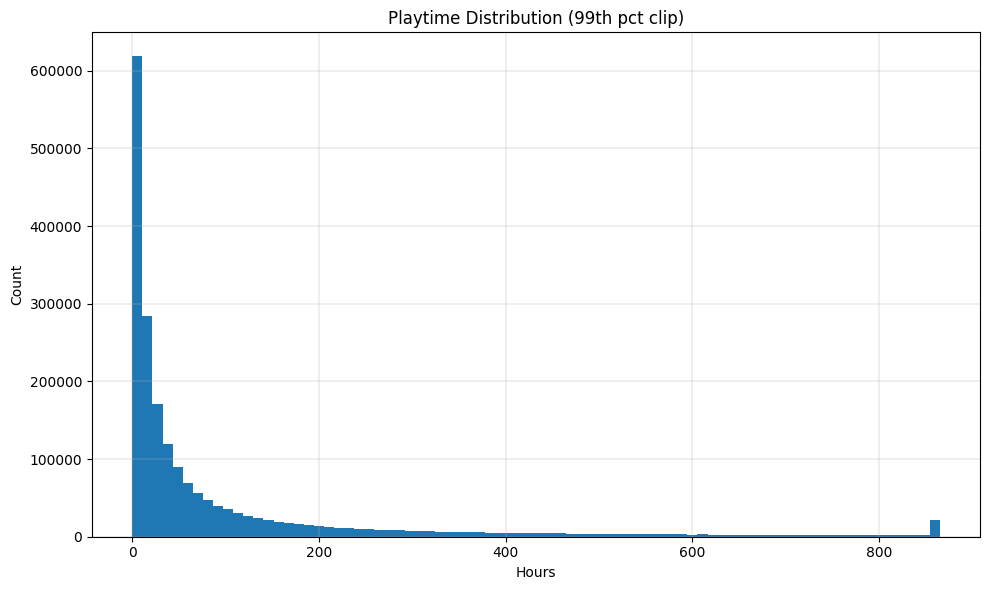

/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_2236/686624140.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([y, n], labels=["Recommended", "Not recommended"], showfliers=False)


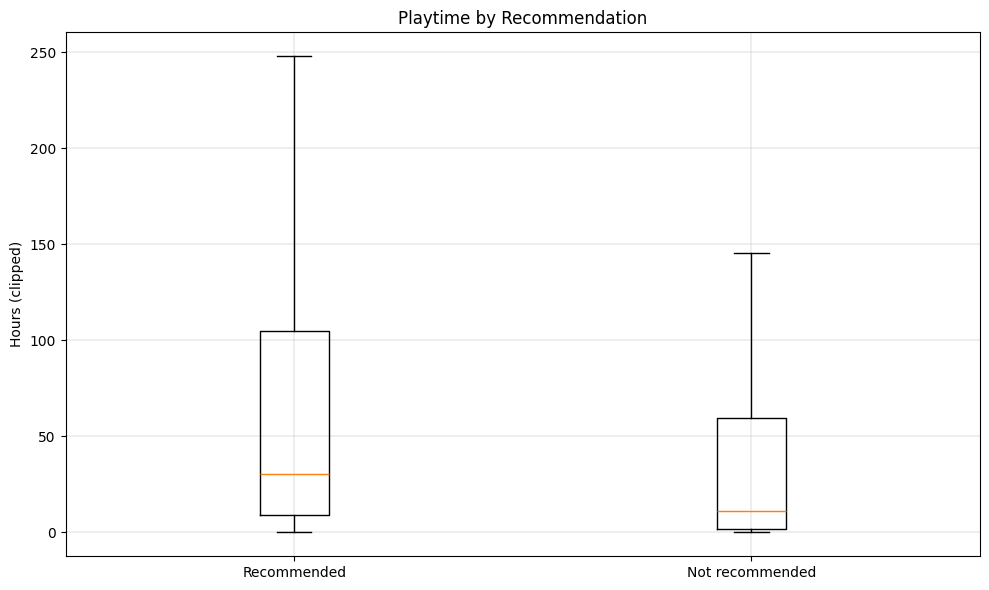

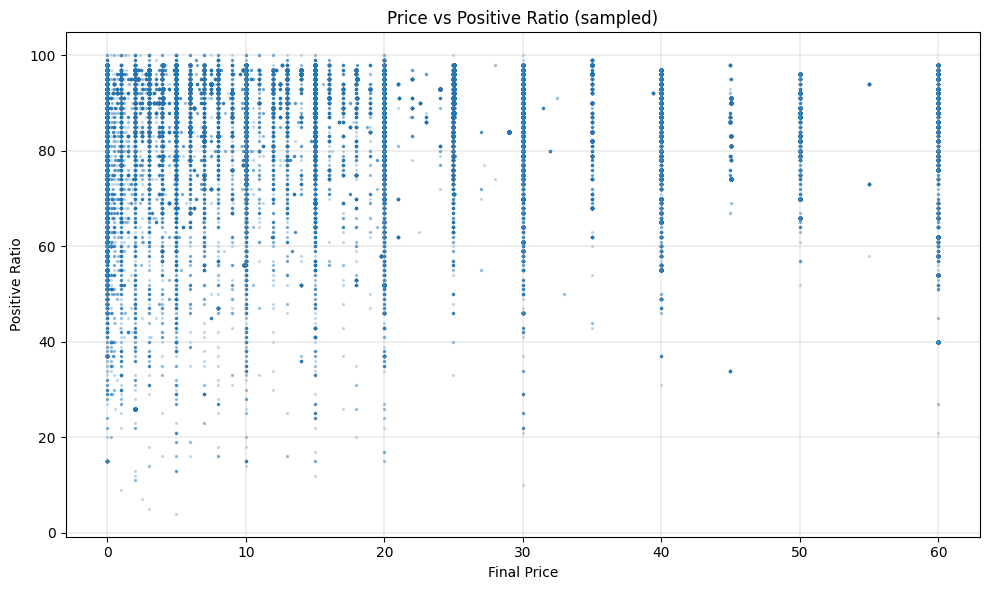

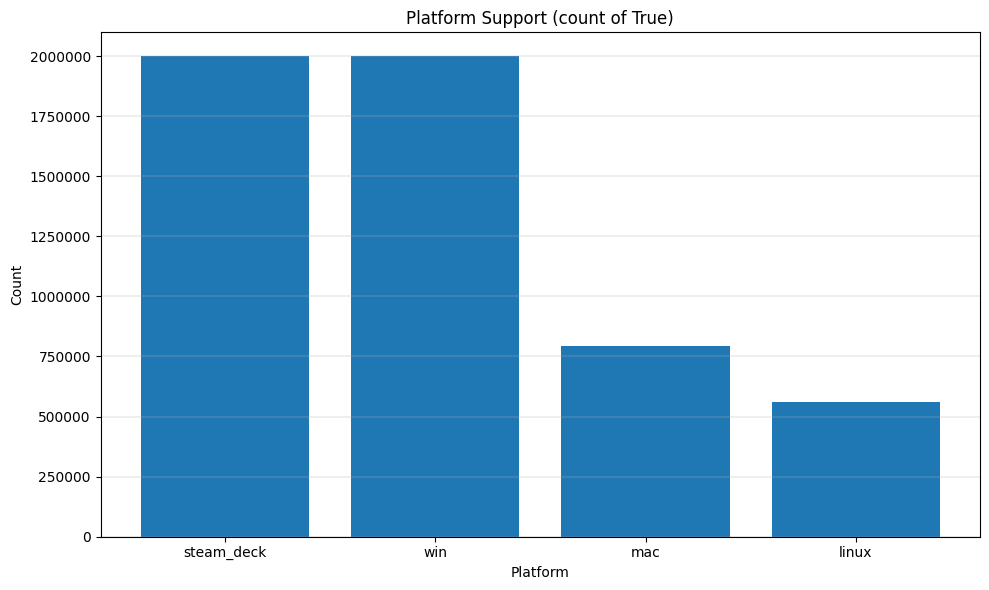

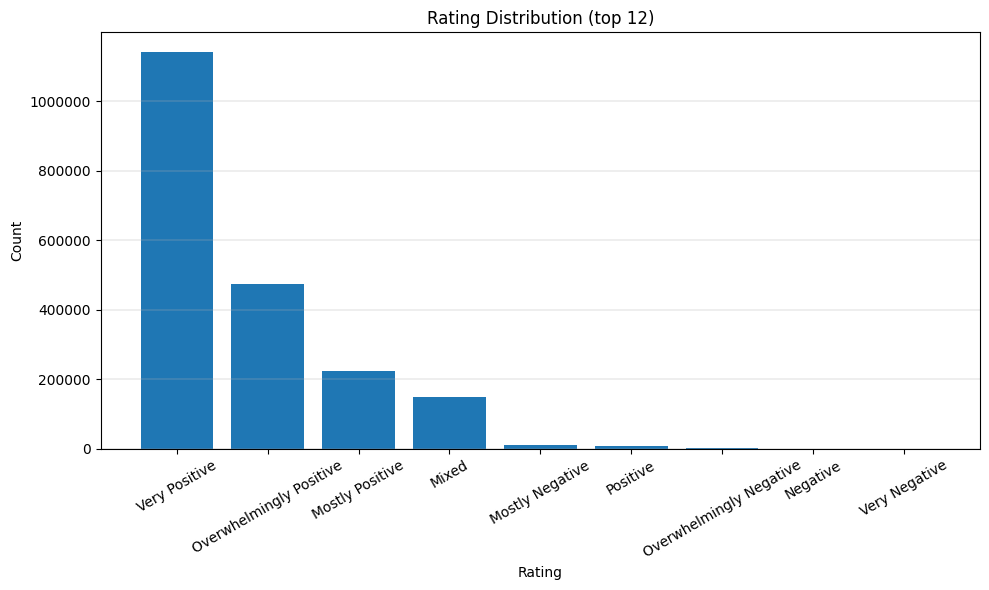

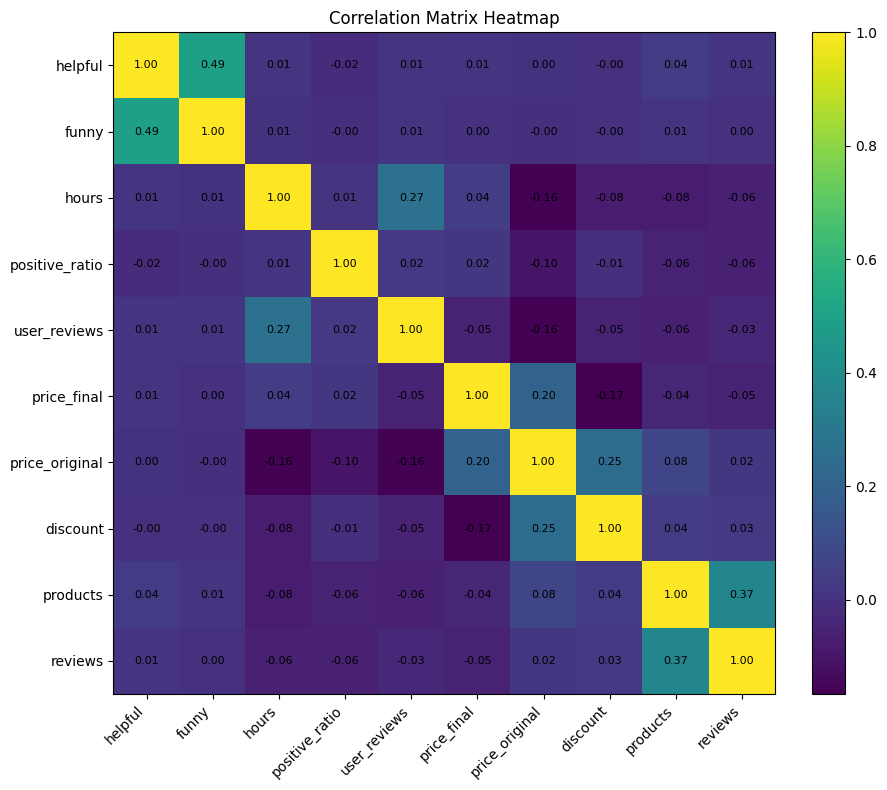

In [6]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

steam = steam.copy()

for c in ["date", "date_release"]:
    if c in steam.columns:
        steam[c] = pd.to_datetime(steam[c], errors="coerce")

if "hours" in steam.columns:
    h_cap = np.nanpercentile(steam["hours"].dropna(), 99)
    steam["hours_clipped"] = steam["hours"].clip(0, h_cap)

if "price_final" in steam.columns:
    p_cap = np.nanpercentile(steam["price_final"].dropna(), 99)
    steam["price_final_clipped"] = steam["price_final"].clip(0, p_cap)

def plain_ticks(ax, which=("x","y")):
    if "x" in which and isinstance(ax.xaxis.get_major_formatter(), mticker.ScalarFormatter):
        ax.xaxis.get_major_formatter().set_scientific(False)
        ax.xaxis.get_major_formatter().set_useOffset(False)
    if "y" in which and isinstance(ax.yaxis.get_major_formatter(), mticker.ScalarFormatter):
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.yaxis.get_major_formatter().set_useOffset(False)

# 1) Playtime histogram
if "hours_clipped" in steam.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(steam["hours_clipped"].dropna(), bins=80)
    ax.set_title("Playtime Distribution (99th pct clip)")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Count")
    ax.grid(True, linewidth=0.3)
    plain_ticks(ax, ("x","y"))
    fig.tight_layout()
    plt.show()

# 2) Playtime by recommendation (box)
if {"hours_clipped", "is_recommended"}.issubset(steam.columns):
    y = steam.loc[steam["is_recommended"] == True, "hours_clipped"].dropna().values
    n = steam.loc[steam["is_recommended"] == False, "hours_clipped"].dropna().values
    if len(y) > 0 and len(n) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.boxplot([y, n], labels=["Recommended", "Not recommended"], showfliers=False)
        ax.set_title("Playtime by Recommendation")
        ax.set_ylabel("Hours (clipped)")
        ax.grid(True, linewidth=0.3)
        plain_ticks(ax, ("y",))
        fig.tight_layout()
        plt.show()

# 3) Price vs positive ratio (scatter, sampled)
if {"price_final_clipped", "positive_ratio"}.issubset(steam.columns):
    s = steam[["price_final_clipped", "positive_ratio"]].dropna()
    s = s.sample(n=min(200_000, len(s)), random_state=42)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(s["price_final_clipped"], s["positive_ratio"], s=2, alpha=0.2)
    ax.set_title("Price vs Positive Ratio (sampled)")
    ax.set_xlabel("Final Price")
    ax.set_ylabel("Positive Ratio")
    ax.grid(True, linewidth=0.3)
    plain_ticks(ax, ("x","y"))
    fig.tight_layout()
    plt.show()

# 4) Platform support (bar)
pl_cols = [c for c in ["win", "mac", "linux", "steam_deck"] if c in steam.columns]
if pl_cols:
    counts = steam[pl_cols].sum().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("Platform Support (count of True)")
    ax.set_xlabel("Platform")
    ax.set_ylabel("Count")
    ax.grid(True, axis="y", linewidth=0.3)
    plain_ticks(ax, ("y",))
    fig.tight_layout()
    plt.show()

# 5) Rating distribution (bar)
if "rating" in steam.columns:
    top_r = steam["rating"].fillna("Unknown").value_counts().head(12)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(top_r.index.astype(str), top_r.values)
    ax.set_title("Rating Distribution (top 12)")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, axis="y", linewidth=0.3)
    plain_ticks(ax, ("y",))
    fig.tight_layout()
    plt.show()

# 6) Correlation heatmap
num_cols = [c for c in [
    "helpful","funny","hours","positive_ratio","user_reviews",
    "price_final","price_original","discount","products","reviews"
] if c in steam.columns]
if len(num_cols) >= 2:
    corr = steam[num_cols].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr, interpolation="nearest")
    ax.set_title("Correlation Matrix Heatmap")
    fig.colorbar(im, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(num_cols)), labels=num_cols, rotation=45, ha="right")
    ax.set_yticks(range(len(num_cols)), labels=num_cols)
    for i in range(len(num_cols)):
        for j in range(len(num_cols)):
            ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha="center", va="center", fontsize=8)
    fig.tight_layout()
    plt.show()


##### Cleaning

In [7]:
def clean_steam(df, clip_q=0.99):
    import pandas as pd
    import numpy as np

    df = df.copy()

    # dates
    for c in ["date", "date_release"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True).dt.tz_localize(None)

    # text
    for c in ["title", "description"]:
        if c in df.columns:
            s = df[c].astype("string")
            df[c] = s.str.strip().replace("", pd.NA)

    # rating -> ordered category
    if "rating" in df.columns:
        r = df["rating"].astype("string").str.strip().str.lower().str.replace(r"\s+", " ", regex=True)
        cats = [
            "overwhelmingly negative","very negative","negative","mostly negative",
            "mixed","mostly positive","positive","very positive","overwhelmingly positive"
        ]
        df["rating"] = pd.Categorical(r.where(r.isin(cats)), categories=cats, ordered=True)

    # bounds and caps
    if "positive_ratio" in df.columns:
        df["positive_ratio"] = pd.to_numeric(df["positive_ratio"], errors="coerce").clip(0, 100)

    if "hours" in df.columns:
        df["hours"] = pd.to_numeric(df["hours"], errors="coerce")
        df.loc[df["hours"] < 0, "hours"] = np.nan
        cap = df["hours"].quantile(clip_q)
        if np.isfinite(cap):
            df["hours"] = df["hours"].clip(upper=float(cap))

    # prices and discount
    if {"price_final", "price_original"}.issubset(df.columns):
        pf = pd.to_numeric(df["price_final"], errors="coerce").where(lambda x: x >= 0)
        po = pd.to_numeric(df["price_original"], errors="coerce").where(lambda x: x >= 0)
        po = np.where((pd.notna(po)) & (pd.notna(pf)) & (po < pf), pf, po)
        df["price_final"] = pf
        df["price_original"] = po

    if {"price_final", "price_original", "discount"}.issubset(df.columns):
        pf, po = df["price_final"], df["price_original"]
        disc = pd.to_numeric(df["discount"], errors="coerce")
        calc = (1 - (pf / po)).where(po > 0)
        df["discount"] = disc.where((disc >= 0) & (disc <= 1), calc).clip(0, 1)

    # booleans and platform summary
    for c in ["win", "mac", "linux", "steam_deck"]:
        if c in df.columns:
            df[c] = df[c].astype("boolean")
    if {"win", "mac", "linux"}.issubset(df.columns):
        df["platform_count"] = df[["win", "mac", "linux"]].sum(axis=1, min_count=1)

    # tags normalized (string, lightweight)
    if "tags" in df.columns:
        t = df["tags"].astype("string").str.strip().str.lower()
        t = t.str.replace(r"[\[\]{}'\"\s]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
        df["tags"] = t.mask(t == "")

    # dedupe by review_id, prefer newest
    if "review_id" in df.columns:
        df = df.sort_values("date", kind="stable").drop_duplicates("review_id", keep="last")

    # required keys present
    keys = [c for c in ["app_id", "user_id", "review_id"] if c in df.columns]
    if keys:
        df = df.dropna(subset=keys)

    return df

# usage
steam = clean_steam(steam)


In [8]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000001 entries, 1260925 to 1999546
Data columns (total 27 columns):
 #   Column               Dtype         
---  ------               -----         
 0   app_id               int64         
 1   helpful              int64         
 2   funny                int64         
 3   date                 datetime64[ns]
 4   is_recommended       bool          
 5   hours                float64       
 6   user_id              int64         
 7   review_id            int64         
 8   title                string        
 9   date_release         datetime64[ns]
 10  win                  boolean       
 11  mac                  boolean       
 12  linux                boolean       
 13  rating               category      
 14  positive_ratio       int64         
 15  user_reviews         int64         
 16  price_final          float64       
 17  price_original       float64       
 18  discount             float64       
 19  steam_deck          

##### Encoding

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def encode_steam(steam: pd.DataFrame,
                 tag_max_features: int = 256,
                 tag_sample: int = 1_000_000) -> pd.DataFrame:
    # numerics except booleans
    numeric_cols = [
        c for c in steam.columns
        if pd.api.types.is_numeric_dtype(steam[c])
        and not pd.api.types.is_bool_dtype(steam[c])
    ]
    parts = [steam[numeric_cols]]

    # booleans -> UInt8
    bool_cols = [c for c in steam.columns if pd.api.types.is_bool_dtype(steam[c])]
    if bool_cols:
        parts.append(steam[bool_cols].astype("UInt8"))

    # rating -> one-hot UInt8
    if "rating" in steam.columns:
        rat = steam["rating"].astype("string").fillna("NA")
        rat_dum = pd.get_dummies(rat, prefix="rating", dtype="UInt8")
        parts.append(rat_dum)

    # tags -> top-N multi-hot (sparse)
    if "tags" in steam.columns:
        tags_series = steam["tags"].fillna("")
        fit_series = (
            tags_series.sample(tag_sample, random_state=0)
            if len(tags_series) > tag_sample else tags_series
        )
        vec = CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            binary=True,
            max_features=tag_max_features,
            dtype=np.uint8,
        )
        vec.fit(fit_series.tolist())
        X_tags = vec.transform(tags_series.tolist())
        tag_cols = [f"tag_{t}" for t in vec.get_feature_names_out()]
        tags_df = pd.DataFrame.sparse.from_spmatrix(X_tags, index=steam.index, columns=tag_cols)
        parts.append(tags_df)

    # drop obvious text fields if present
    drop_text = [c for c in ("title", "description", "tags") if c in steam.columns]

    X = pd.concat(parts, axis=1)
    X = X.loc[:, ~X.columns.isin(drop_text)]

    return X

# usage
steam = encode_steam(steam, tag_max_features=256)
steam.info()


/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Index: 2000001 entries, 1260925 to 1999546
Columns: 286 entries, app_id to tag_zombies
dtypes: Int64(1), Sparse[uint8, 0](256), UInt8(14), float64(6), int64(9)
memory usage: 399.0 MB


In [10]:
list(steam.columns)

['app_id',
 'helpful',
 'funny',
 'hours',
 'user_id',
 'review_id',
 'positive_ratio',
 'user_reviews',
 'price_final',
 'price_original',
 'discount',
 'products',
 'reviews',
 'hours_clipped',
 'price_final_clipped',
 'platform_count',
 'is_recommended',
 'win',
 'mac',
 'linux',
 'steam_deck',
 'rating_mixed',
 'rating_mostly negative',
 'rating_mostly positive',
 'rating_negative',
 'rating_overwhelmingly negative',
 'rating_overwhelmingly positive',
 'rating_positive',
 'rating_very negative',
 'rating_very positive',
 'tag_1980s',
 'tag_1990 s',
 'tag_2.5d',
 'tag_2d',
 'tag_2d fighter',
 'tag_2d platformer',
 'tag_3d',
 'tag_3d platformer',
 'tag_3d vision',
 'tag_4 player local',
 'tag_action',
 'tag_action roguelike',
 'tag_action rpg',
 'tag_action-adventure',
 'tag_addictive',
 'tag_adventure',
 'tag_aliens',
 'tag_alternate history',
 'tag_anime',
 'tag_arcade',
 'tag_arena shooter',
 'tag_assassin',
 'tag_atmospheric',
 'tag_automobile sim',
 'tag_base building',
 'tag_ba

##### Engineering

In [11]:
def engineer_steam_features(df_in):
    """
    Adds robust, model-ready features and returns (X, y).
    Uses clipped fields when available. Safe against missing cols.
    """
    df = df_in.copy()

    # ---- helpers ----
    def has(c): return c in df.columns
    def cols_start(prefix): return [c for c in df.columns if c.startswith(prefix)]
    def safe_div(num, den):
        den = np.where(den > 0, den, 1.0)
        return num / den

    # ---- basic fills ----
    fill_zeros = [c for c in [
        "helpful","funny","hours","hours_clipped","user_reviews","reviews",
        "positive_ratio","price_final","price_original","price_final_clipped",
        "discount","products"
    ] if has(c)]
    for c in fill_zeros:
        df[c] = df[c].fillna(0)

    # ---- cast binaries to uint8 ----
    bool_like = [c for c in ["is_recommended","win","mac","linux","steam_deck"] if has(c)]
    for c in bool_like:
        df[c] = df[c].astype("uint8")

    tag_cols = cols_start("tag_")
    rating_cols = [c for c in [
        "rating_mixed","rating_mostly negative","rating_mostly positive",
        "rating_negative","rating_overwhelmingly negative",
        "rating_overwhelmingly positive","rating_positive",
        "rating_very negative","rating_very positive"
    ] if has(c)]
    for c in tag_cols + rating_cols:
        df[c] = df[c].fillna(0).astype("uint8")

    # ---- platform features ----
    pcols = [c for c in ["win","mac","linux"] if has(c)]
    if pcols:
        df["platform_count"] = df[pcols].sum(axis=1).astype("uint8")
        if set(pcols) == {"win","mac","linux"}:
            df["platform_all"] = (df["win"] & df["mac"] & df["linux"]).astype("uint8")
            df["platform_windows_only"] = ((df["win"]==1) & (df["mac"]==0) & (df["linux"]==0)).astype("uint8")
            df["platform_mac_only"] = ((df["win"]==0) & (df["mac"]==1) & (df["linux"]==0)).astype("uint8")
            df["platform_linux_only"] = ((df["win"]==0) & (df["mac"]==0) & (df["linux"]==1)).astype("uint8")

    # ---- price/discount/value ----
    if has("price_original") and has("price_final"):
        df["calc_discount_abs"] = (df["price_original"] - df["price_final"]).clip(lower=0).astype("float32")
        df["calc_discount_pct"] = np.where(df["price_original"] > 0,
                                           df["calc_discount_abs"] / df["price_original"], 0.0).astype("float32")
        df["is_free"] = (df["price_final"] <= 0).astype("uint8")
    if has("hours_clipped") and has("price_final_clipped"):
        df["price_per_hour"] = safe_div(df["price_final_clipped"], df["hours_clipped"]).astype("float32")

    # ---- engagement ratios ----
    if has("reviews"):
        den_rev = np.where(df["reviews"] > 0, df["reviews"], 1.0)
        if has("helpful"): df["helpful_rate"] = (df["helpful"] / den_rev).astype("float32")
        if has("funny"):   df["funny_rate"]   = (df["funny"]   / den_rev).astype("float32")
        if has("helpful") and has("funny"):
            df["interaction_rate"] = ((df["helpful"] + df["funny"]) / den_rev).astype("float32")
    if has("hours_clipped") and has("helpful") and has("funny"):
        df["interactions_per_hour"] = safe_div(df["helpful"] + df["funny"], df["hours_clipped"]).astype("float32")

    # ---- log1p stabilizers ----
    for c in ["helpful","funny","reviews","user_reviews","price_final_clipped","price_original","hours_clipped","products"]:
        if has(c):
            df[f"{c}_log1p"] = np.log1p(df[c]).astype("float32")

    # ---- normalized sentiment ----
    if has("positive_ratio"):
        df["pos_ratio_norm"] = (df["positive_ratio"] / 100.0).astype("float32")

    # ---- rating score (one-hot -> scalar) ----
    rating_weights = {
        "rating_overwhelmingly positive":  2.0,
        "rating_very positive":            1.5,
        "rating_positive":                 1.0,
        "rating_mostly positive":          0.5,
        "rating_mixed":                    0.0,
        "rating_mostly negative":         -0.5,
        "rating_negative":                -1.0,
        "rating_very negative":           -1.5,
        "rating_overwhelmingly negative": -2.0,
    }
    if rating_cols:
        rs = np.zeros(len(df), dtype="float32")
        for col, w in rating_weights.items():
            if has(col):
                rs = rs + df[col].values.astype("float32") * w
        df["rating_score"] = rs.astype("float32")

    # ---- tag aggregates ----
    if tag_cols:
        df["tag_count"] = df[tag_cols].sum(axis=1).astype("uint16")
        adult = [c for c in ["tag_nsfw","tag_nudity","tag_sexual content","tag_mature","tag_hentai"] if has(c)]
        if adult: df["adult_content_tags"] = df[adult].sum(axis=1).clip(upper=5).astype("uint8")
        viol = [c for c in ["tag_gore","tag_violent","tag_blood","tag_horror","tag_survival horror","tag_psychological horror"] if has(c)]
        if viol: df["violence_tags"] = df[viol].sum(axis=1).clip(upper=6).astype("uint8")
        coop = [c for c in ["tag_co-op","tag_local co-op","tag_online co-op","tag_team-based","tag_pve","tag_pvp","tag_multiplayer","tag_split screen","tag_local multiplayer"] if has(c)]
        if coop: df["coop_pvp"] = df[coop].sum(axis=1).clip(upper=9).astype("uint8")
        hardcore = [c for c in ["tag_roguelike","tag_roguelite","tag_souls-like","tag_metroidvania","tag_difficult"] if has(c)]
        if hardcore: df["hardcore_tags"] = df[hardcore].sum(axis=1).clip(upper=5).astype("uint8")
        genres = [c for c in ["tag_action","tag_adventure","tag_strategy","tag_rpg","tag_simulation","tag_sports","tag_indie"] if has(c)]
        if genres: df["genre_tags"] = df[genres].sum(axis=1).clip(upper=7).astype("uint8")

    # ---- build X, y ----
    y = df["is_recommended"].astype("uint8") if has("is_recommended") else None

    base_feats = [c for c in [
        "hours_clipped","price_final_clipped","price_per_hour",
        "price_original","calc_discount_abs","calc_discount_pct","is_free",
        "platform_count","platform_all","platform_windows_only","platform_mac_only","platform_linux_only",
        "pos_ratio_norm","rating_score",
        "helpful_rate","funny_rate","interaction_rate","interactions_per_hour",
        "helpful_log1p","funny_log1p","reviews_log1p","user_reviews_log1p","hours_log1p","price_final_clipped_log1p","price_original_log1p","products_log1p",
        "adult_content_tags","violence_tags","coop_pvp","hardcore_tags","genre_tags",
        "steam_deck","win","mac","linux",
        "positive_ratio","user_reviews","products","reviews","discount","price_final"
    ] if has(c)]

    X = df[base_feats + tag_cols + rating_cols].copy()

    # dtype tighten for floats
    float_cols = X.select_dtypes(include=["float64"]).columns
    if len(float_cols):
        X[float_cols] = X[float_cols].astype("float32")

    return X, y

X, y = engineer_steam_features(steam)
X.shape, None if y is None else y.shape

/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_2236/3442238188.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["platform_all"] = (df["win"] & df["mac"] & df["linux"]).astype("uint8")
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_2236/3442238188.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["platform_windows_only"] = ((df["win"]==1) & (df["mac"]==0) & (df["linux"]==0)).astype("uint8")
/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_2236/3442238188.py:46: PerformanceWarning: Da

((2000001, 305), (2000001,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

##### Selection

In [21]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import is_classifier as sk_is_classifier

def backward_feature_selection_v2(
    X, y, model,
    scoring="f1_macro",
    cv=3,
    tol=0.005,
    prefilter_k=200,
    candidate_k=50,
    min_features=1,
    n_jobs=-1,
    random_state=0,
    feature_names=None,
    verbose=True,
):
    # names
    if feature_names is not None:
        names = list(feature_names)
    elif hasattr(X, "columns"):
        names = list(X.columns)
    else:
        names = [f"f{i}" for i in range(X.shape[1])]

    X_arr = X.values if hasattr(X, "values") else np.asarray(X)
    y_arr = np.asarray(y)

    # CV
    try:
        is_clf = sk_is_classifier(model)
    except Exception:
        is_clf = np.unique(y_arr).size <= 20
    if isinstance(cv, int):
        cv = StratifiedKFold(cv, shuffle=True, random_state=random_state) if is_clf \
             else KFold(cv, shuffle=True, random_state=random_state)

    # leakage-safe prefilter: rank per fold, then aggregate
    rf = (RandomForestClassifier(n_estimators=200, n_jobs=n_jobs, random_state=random_state)
          if is_clf else
          RandomForestRegressor(n_estimators=200, n_jobs=n_jobs, random_state=random_state))
    agg = np.zeros(X_arr.shape[1])
    for tr, _ in cv.split(X_arr, y_arr):
        rf.fit(X_arr[tr], y_arr[tr])
        agg += getattr(rf, "feature_importances_", np.zeros_like(agg))
    keep0 = np.argsort(agg)[::-1][:min(prefilter_k, X_arr.shape[1])]
    current = sorted(keep0.tolist())
    if verbose:
        print(f"Prefilter kept {len(current)} features.")

    # baseline
    best_mean = cross_val_score(model, X_arr[:, current], y_arr, scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
    peak_mean, peak_set = best_mean, current.copy()
    if verbose:
        print(f"Initial CV = {best_mean:.6f} with {len(current)} features.")

    while len(current) > min_features:
        # recompute importances on current columns
        rf.fit(X_arr[:, current], y_arr)
        imps = rf.feature_importances_
        order = np.argsort(imps)[:min(candidate_k, len(current))]  # weakest
        cands = [current[i] for i in order]

        # try removing each candidate
        scores = []
        for j in cands:
            cols = [c for c in current if c != j]
            cv_scores = cross_val_score(model, X_arr[:, cols], y_arr, scoring=scoring, cv=cv, n_jobs=n_jobs)
            scores.append((j, cv_scores.mean(), cv_scores.std()))

        # choose best removal
        j, mean_new, std_new = max(scores, key=lambda t: t[1])

        # accept only if not worse than tol and not worse than 0.25*std
        if mean_new < best_mean - max(tol, 0.25 * std_new):
            if verbose:
                print("Stopping early (removal hurts beyond tolerance).")
            break

        # commit removal
        current.remove(j)
        best_mean = mean_new
        if best_mean > peak_mean:
            peak_mean, peak_set = best_mean, current.copy()
        if verbose:
            print(f"Removed {names[j]} -> CV = {best_mean:.6f} (k={len(current)})")

    selected_features = [names[i] for i in current]
    best_subset = [names[i] for i in peak_set]
    if verbose:
        print(f"Best Features: {best_subset}")
        print(f"Best CV {scoring}: {peak_mean:.6f}")

    return selected_features, best_subset, peak_mean


In [23]:
from sklearn.tree import DecisionTreeClassifier

# final model you want to evaluate
model = DecisionTreeClassifier(random_state=42, max_depth=5)

# run the selector (use raw X for tree models, not scaled)
selected, best_subset, best_cv = backward_feature_selection_v2(
    X_train, y_train, model,
    scoring="f1_macro",
    cv=2,
    tol=0.1,
    prefilter_k=20,
    candidate_k=10,
    n_jobs=-1,
    random_state=42,
    feature_names=X_train.columns,
    verbose=True
)

print("Best subset size:", len(best_subset))
print("Best CV:", best_cv)
print("Best features:", best_subset)

Prefilter kept 20 features.
Initial CV = 0.620247 with 20 features.
Removed helpful_rate -> CV = 0.623668 (k=19)
Removed helpful_log1p -> CV = 0.624252 (k=18)
Removed funny_log1p -> CV = 0.624252 (k=17)
Removed rating_mixed -> CV = 0.624252 (k=16)
Removed funny_rate -> CV = 0.624252 (k=15)
Removed price_final -> CV = 0.624252 (k=14)
Removed rating_score -> CV = 0.624252 (k=13)
Removed price_final_clipped -> CV = 0.624252 (k=12)
Removed reviews_log1p -> CV = 0.624252 (k=11)
Removed user_reviews_log1p -> CV = 0.624252 (k=10)
Removed pos_ratio_norm -> CV = 0.624252 (k=9)
Removed reviews -> CV = 0.624252 (k=8)
Removed products -> CV = 0.624252 (k=7)
Removed products_log1p -> CV = 0.624252 (k=6)
Removed interactions_per_hour -> CV = 0.624094 (k=5)
Removed price_per_hour -> CV = 0.620950 (k=4)
Removed user_reviews -> CV = 0.606325 (k=3)
Removed interaction_rate -> CV = 0.566233 (k=2)
Removed hours_clipped -> CV = 0.536570 (k=1)
Best Features: ['hours_clipped', 'price_final_clipped', 'price_p

##### Modeling

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold  # Add this

X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

forest_model = RandomForestClassifier(random_state=42)
forest_cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42)  # Changed to stratified

forest_scores = cross_val_score(
    forest_model,
    X_scaled_df[best_subset],
    y_train,
    scoring="f1_macro",
    cv=forest_cv,
    n_jobs=-1
)

print("CV F1_macro:", f"{forest_scores.mean():.6f}")
print("STD CV F1_macro:", f"{forest_scores.std():.6f}")

CV F1_macro: 0.660855
STD CV F1_macro: 0.001278


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold  # Add this

X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

boosting_model = GradientBoostingClassifier(random_state=42)
forest_cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42)  # Changed to stratified

forest_scores = cross_val_score(
    boosting_model,
    X_scaled_df[best_subset],
    y_train,
    scoring="f1_macro",
    cv=forest_cv,
    n_jobs=-1
)

print("CV F1_macro:", f"{forest_scores.mean():.6f}")
print("STD CV F1_macro:", f"{forest_scores.std():.6f}")

/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV F1_macro: 0.640726
STD CV F1_macro: 0.001289


In [ ]:
def float_range(start, stop, step):
    vals = []
    x = start
    while x <= stop:
        vals.append(x)
        x += step
    return vals

param_distributions = {
    "n_estimators": range(100, 501, 100),
    "max_depth": range(2, 25, 1),
    "min_samples_split": range(2, 25, 1),
    "min_samples_leaf": range(1, 25, 1),
    "max_features": float_range(0.1, 1.01, 0.1),
}

random_search = RandomizedSearchCV(
    estimator           = RandomForestRegressor(random_state=42),
    param_distributions = param_distributions,
    n_iter              = 100,
    cv                  = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
    scoring             = "neg_mean_absolute_error",
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

random_search.fit(X_train, y_train)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# add a column with the *positive* MAE
results_df["mae"] = -results_df["mean_test_score"]

# sort by the *lowest* MAE and take the top 10
top10 = results_df.sort_values(by="mae").head(10)

print("Top 10 models (by MAE):")
print(top10[["params", "mae", "std_test_score"]])

# rint the best‐found parameters and *positive* scores
print("Best parameters:", random_search.best_params_)
print("Best CV MAE: {:.3f}".format(-random_search.best_score_))

NameError: name 'X_train_scaled_df' is not defined

### Olist Transactions

##### EDA

In [ ]:
olist

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_value_total,payment_installments_max,payment_count,review_score_mean,review_count
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,13.000000,housewares,9350.000000,maua,SP,38.710000,1.000000,3.000000,4.000000,1.000000
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,19.000000,perfumery,31570.000000,belo horizonte,SP,141.460000,1.000000,1.000000,4.000000,1.000000
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,21.000000,auto,14840.000000,guariba,SP,179.120000,3.000000,1.000000,5.000000,1.000000
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,20.000000,pet_shop,31842.000000,belo horizonte,MG,72.200000,1.000000,1.000000,5.000000,1.000000
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,15.000000,stationery,8752.000000,mogi das cruzes,SP,28.620000,1.000000,1.000000,5.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,...,40.000000,baby,17602.000000,tupa,SP,195.000000,3.000000,1.000000,4.000000,1.000000
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,...,22.000000,home_appliances_2,8290.000000,sao paulo,SP,271.010000,5.000000,1.000000,5.000000,1.000000
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,20.000000,computers_accessories,37175.000000,ilicinea,MG,441.160000,4.000000,1.000000,2.000000,1.000000
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,...,20.000000,computers_accessories,37175.000000,ilicinea,MG,441.160000,4.000000,1.000000,2.000000,1.000000


##### Cleaning

##### Encoding

##### Engineering

##### Modeling

### Global Game Sales

In [ ]:
sales

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.700000,...,NaN,NaN,NaN,NaN,2006.000000,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.000000,...,NaN,NaN,NaN,NaN,1985.000000,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.200000,...,NaN,NaN,NaN,NaN,2008.000000,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.700000,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.000000,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.000000,...,NaN,NaN,NaN,NaN,2009.000000,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.800000,/games/boxart/full_7295041AmericaFrontccc.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55787,55788,Indivisible,indivisible,Role-Playing,NaN,PC,505 Games,Lab Zero Games,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224682/indivisibl...,1,NaN,/games/boxart/full_6339426AmericaFrontccc.jpg
55788,55789,Lost Ember,lost-amber,Adventure,RP,PC,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/games/game.php?id=2246...,1,NaN,/games/boxart/full_8893129AmericaFrontccc.jpg
55789,55790,Lost Ember,lost-amber,Adventure,RP,PS4,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224690/lost-ember...,1,NaN,/games/boxart/full_6514293AmericaFrontccc.jpg
55790,55791,Lost Ember,lost-amber,Adventure,RP,XOne,Mooneye Studios,Mooneye Studios,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.000000,11th Apr 19,http://www.vgchartz.com/game/224688/lost-ember...,1,NaN,/games/boxart/full_6799693AmericaFrontccc.jpg


##### EDA

##### Cleaning

##### Encoding

##### Engineering

##### Modeling